# Gene Modulation Example
The goal of this notebook is to illustrate basic usage of I/O functionality in the [`cmapR`](https://github.com/cmap/cmapR) package. As a case study, we'll be analyzing signatures of compounds that do and do not modulate the gene MYC.

## Setup

In [3]:
# load cmapR library
library(cmapR)

# load data.table for fast reading of text files
library(data.table)

# load pheatmap for plotting heatmaps
suppressWarnings(library(pheatmap))

Warning message:
“package ‘pheatmap’ was built under R version 3.2.3”

Set up paths for matrix and metadata. Adjust these as needed.

In [4]:
ds_path <- "/cmap/projects/M1/DATASETS/GEO/matrices/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx"
siginfo_path <- "/cmap/projects/M1/DATASETS/GEO/metadata/siginfo_combined.txt"
geneinfo_path <- "/cmap/projects/M1/DATASETS/GEO/metadata/GSE92742_Broad_LINCS_gene_info.txt"

Load the metadata for all CMap signatures

In [5]:
# suppressing warnings so that we don't have to see
# fread complain about inconsistencies in some of the
# metadata columns
siginfo <- suppressWarnings(data.table::fread(siginfo_path))

Read 473626 rows and 21 (of 21) columns from 0.117 GB file in 00:00:03


And for genes

In [6]:
geneinfo <- data.table::fread(geneinfo_path)

Designate my gene of interest using its gene symbol.



In [7]:
my_gene <- "MYC"

Look up the corresponding gene_id, since this will correspond to row ids in the data matrix

In [8]:
my_gene_id <- geneinfo[pr_gene_symbol==my_gene]$pr_gene_id

Figure out list of signature ids (sig_ids) corresponding to compounds in the cell line A375, where the given signature had exactly 3 replicates. This is somewhat arbitrary but useful in reducing the number of signatures we're dealing with.

In [9]:
sigs_of_interest <- siginfo[pert_type=="trt_cp" &
                  cell_id=="A375" & 
                  distil_nsample==3]
sig_ids <- sigs_of_interest$sig_id

How many did we get?

In [10]:
length(sig_ids)

[1] 7020

Now slice out the corresponding rows and columns from the data matrix using parse.gctx, which will return an object of class GCT. Make sure to cast the gene_id as a character so it's not mistakenly interpreted as an integer index.

In [11]:
ds <- cmapR::parse.gctx(ds_path,
                        rid=as.character(my_gene_id),
                        cid=sig_ids)

reading /cmap/projects/M1/DATASETS/GEO/matrices/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
done


Let's take a look at the structure of the object we can do this by simply typing its name

In [12]:
ds

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1, 1:7020] 0.0869 -0.5384 -0.6922 0.5781 1.0301 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr "4609"
  .. .. ..$ : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rid    : chr "4609"
  ..@ cid    : chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ rdesc  :'data.frame':	1 obs. of  1 variable:
  .. ..$ id: chr "4609"
  ..@ cdesc  :'data.frame':	7020 obs. of  1 variable:
  .. ..$ id: chr [1:7020] "CPC004_A375_6H:BRD-A00546892-001-01-8:10" "CPC004_A375_6H:BRD-A00993607-003-15-4:10" "CPC004_A375_6H:BRD-A01593789-001-02-3:10" "CPC004_A375_6H:BRD-A01643550-001-03-1:10" ...
  ..@ version: chr(0) 
  ..@ src    : chr "/cmap/p

We're interested in the data matrix, located in the slot `@mat`. Let's look at the distribution of z-scores. We'll add some vertical lines to indicate the thresholds for modulation.

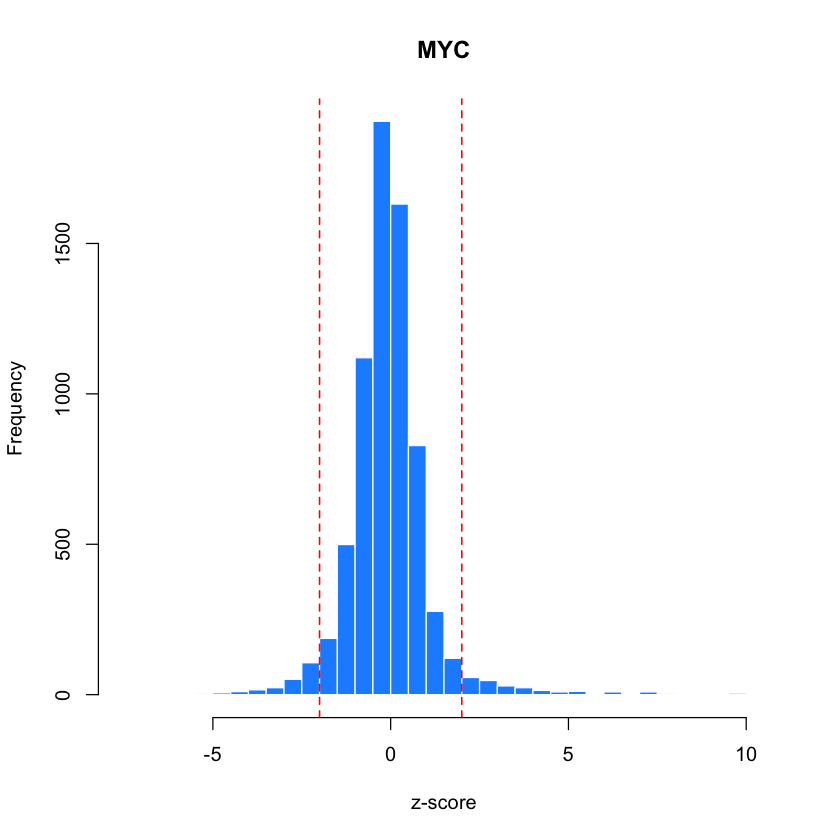

In [13]:
hist(ds@mat, col="dodgerblue", border="white", breaks=30, main=my_gene, xlab="z-score")
abline(v=2, lty=2, col=2, lwd=1.3)
abline(v=-2, lty=2, col=2, lwd=1.3)

Lets identify the signatures in which the gene was significantly modulated.

In [14]:
mod_idx <- which(abs(ds@mat[1, ]) > 2)

How many are there?

In [15]:
length(mod_idx)

[1] 451

Let's compare these signatures to each other to see whether they have any similarity. For comparison, we'll include roughly the same number of signatures in which the gene was **NOT** modulated.

In [16]:
non_mod_idx <- which(abs(ds@mat[1, ]) < 0.06)
length(non_mod_idx)

[1] 456

Good, this is roughly and equal number. Slice out the signatures from the matrix, restricting to landmark space

In [17]:
lm_ids <- as.character(geneinfo[pr_is_lm==1]$pr_gene_id)
ds2 <- parse.gctx(ds_path, rid=lm_ids,
                  cid=c(names(mod_idx), names(non_mod_idx)))


reading /cmap/projects/M1/DATASETS/GEO/matrices/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
done


Compute all pairwise correlations between signatures

In [18]:
corr <- cor(ds2@mat, method="spearman")

Cluster the correlations, overlaying a color bar indicating the degree of modulation of our gene of interest

In [19]:
mod_df <- data.frame(mod=ds@mat[, c(mod_idx, non_mod_idx)])
rownames(mod_df) <- c(names(mod_idx), names(non_mod_idx))

Plot as a heatmap using the `pheatmap` package

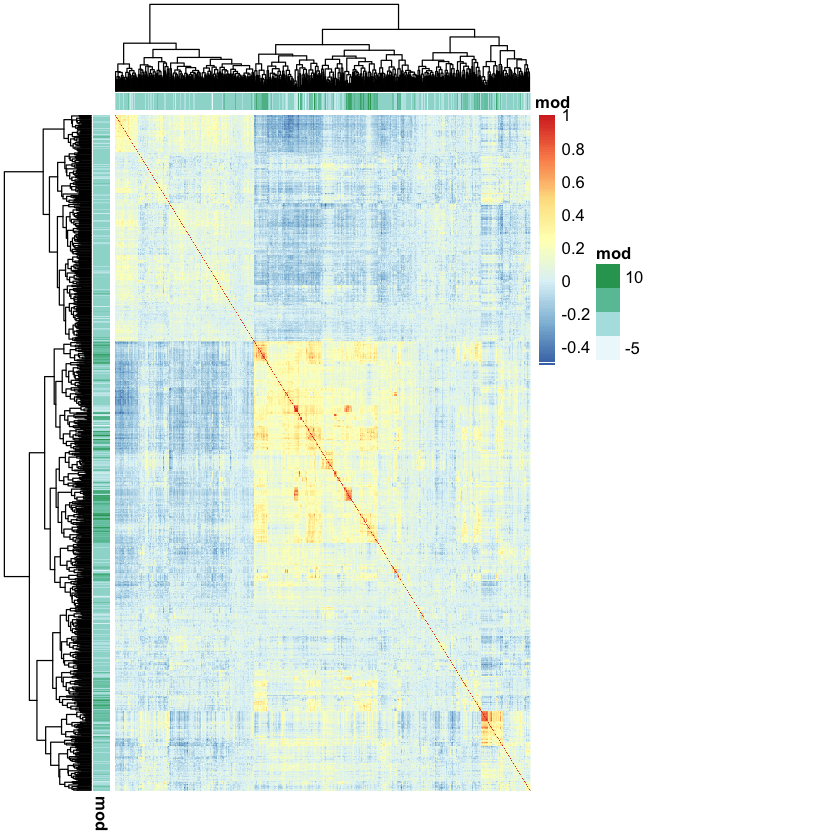

In [20]:
pheatmap::pheatmap(corr, annotation_row=mod_df, annotation_col=mod_df,
                  show_rownames=F, show_colnames=F)

Seems like we do see ~2 clusters which roughly correspond to the signatures in wich our gene is modulated. Not perfect but definitely a trend.